In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [270]:
# Load the datasets
base_station_info = pd.read_csv(r'C:\Users\nadil\OneDrive\Documents\UoM\Sem 5\DSE Project\5g-energy-consumption-modeling\Dataset\BSinfo.csv')
cell_level_data = pd.read_csv(r'C:\Users\nadil\OneDrive\Documents\UoM\Sem 5\DSE Project\5g-energy-consumption-modeling\Dataset\CLdata.csv')
energy_consumption_data = pd.read_csv(r'C:\Users\nadil\OneDrive\Documents\UoM\Sem 5\DSE Project\5g-energy-consumption-modeling\Dataset\ECdata.csv')
sample_submission = pd.read_csv(r'C:\Users\nadil\OneDrive\Documents\UoM\Sem 5\DSE Project\5g-energy-consumption-modeling\Dataset\SampleSubmission.csv').drop("w", axis=1)
power = pd.read_csv(r'C:\Users\nadil\OneDrive\Documents\UoM\Sem 5\DSE Project\5g-energy-consumption-modeling\Dataset\power_consumption_prediction.csv').drop("Energy", axis=1)


In [271]:
power['BS'] = 'B_' + power['BS'].astype(str)

# Data Preprocessing 

In [272]:
base_station_info.CellName.value_counts()

CellName
Cell0    1020
Cell1     193
Cell2       2
Cell3       2
Name: count, dtype: int64

### base_station_info Changes:


In [273]:
base_station_info = base_station_info[base_station_info.CellName.isin(['Cell0', 'Cell1'])]
df = base_station_info.copy()

# Filter rows where CellName is Cell1
cell1_df = df[df['CellName'] == 'Cell1'].copy()

# Rename columns
rename_columns = {
    'RUType': 'RUType_1',
    'Mode': 'Mode_1',
    'Frequency': 'Frequency_1',
    'Bandwidth': 'Bandwidth_1',
    'Antennas': 'Antennas_1',
    'TXpower': 'TXpower_1'
}
cell1_df.rename(columns=rename_columns, inplace=True)

# Drop the CellName column
cell1_df.drop(columns=['CellName'], inplace=True)

# Merge the modified dataframe with the original one based on the BS column
result_df = pd.merge(df, cell1_df, on='BS', how='left')

base_station_info = result_df[result_df.CellName=='Cell0']


In [274]:
base_station_info.drop(columns=["Mode_1", 'RUType_1'], inplace=True)

base_station_info = base_station_info.fillna(-10)

### cell_level_data Changes:

In [275]:
# ESmode4 and ESMode5 contains only 0 or (99.9% contains 0) so it's better to drop it
cell_level_data.drop(columns=["ESMode4", 'ESMode5'],inplace=True)

active_cells = cell_level_data.groupby(["BS", 'Time']).CellName.nunique()
cell_level_data['active_cells'] = cell_level_data.set_index(["BS", 'Time']).index.map(active_cells)

cell_level_data = cell_level_data[cell_level_data.CellName.isin(['Cell0', 'Cell1'])]

df = cell_level_data.copy()

# Filter rows where CellName is Cell1
cell1_df = df[df['CellName'] == 'Cell1'].copy()

# Rename columns
rename_columns = {
    'load': 'load_1',
    'ESMode1': 'ESMode1_1',
    'ESMode2': 'ESMode2_1',
    'ESMode3': 'ESMode3_1',
    'ESMode6': 'ESMode6_1'
}
cell1_df.rename(columns=rename_columns, inplace=True)

# Drop the CellName column
cell1_df.drop(columns=['CellName', 'active_cells'], inplace=True)

# Merge the modified dataframe with the original one based on the BS and Time columns
result_df = pd.merge(df, cell1_df, on=['BS', 'Time'], how='left')

cell_level_data = result_df[result_df.CellName=='Cell0']

cols = ['ESMode1_1', 'ESMode2_1', 'ESMode3_1',
       'ESMode6_1']
cell_level_data['load_1'] = cell_level_data['load_1'].fillna(0)
cell_level_data[cols] = cell_level_data[cols].fillna(-1)

In [276]:
cell_level_data["load_sum"] = cell_level_data[["load", "load_1"]].sum(1)
cell_level_data["load_mult"] = cell_level_data["load"] * cell_level_data["load_1"]

In [277]:
import re

def convert_datetime_format(date_str):
    match = re.match(r'(\d{4})-(\d{2})-(\d{2}) (\d{2}):(\d{2}):\d{2}', date_str)
    
    if match:
        # Extracting year, month, day, hour and minute from the match
        year, month, day, hour, minute = match.groups()
        
        # Convert to the desired format
        new_date_str = "{}/{}/{} {}:{}".format(int(month), int(day), year, int(hour), minute)
        
        return new_date_str
    else:
        return None  # Return None if the input string doesn't match the expected pattern

power['Time'] = power['Time'].apply(convert_datetime_format)

In [278]:
energy_consumption_data["train"]=1
power["train"]=0

In [279]:
data = pd.concat([energy_consumption_data,power])

In [280]:
base_station_info

,BS,CellName,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,Frequency_1,Bandwidth_1,Antennas_1,TXpower_1
0,B_0,Cell0,Type1,Mode2,365.000,20,4,6.875934,426.98,2.0,4.0,7.327504
1,B_1,Cell0,Type2,Mode2,532.000,20,4,6.875934,-10.00,-10.0,-10.0,-10.000000
2,B_2,Cell0,Type1,Mode2,365.000,20,4,6.875934,426.98,2.0,4.0,7.327504
3,B_3,Cell0,Type2,Mode2,532.000,20,4,6.875934,-10.00,-10.0,-10.0,-10.000000
4,B_4,Cell0,Type2,Mode2,532.000,20,4,6.875934,-10.00,-10.0,-10.0,-10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1015,B_1015,Cell0,Type11,Mode1,697.002,10,8,8.046487,-10.00,-10.0,-10.0,-10.000000
1016,B_1016,Cell0,Type11,Mode1,697.002,10,8,8.046487,-10.00,-10.0,-10.0,-10.000000
1017,B_1017,Cell0,Type11,Mode1,697.002,10,8,8.046487,-10.00,-10.0,-10.0,-10.000000
1018,B_1018,Cell0,Type5,Mode2,426.980,2,2,7.325859,-10.00,-10.0,-10.0,-10.000000


In [281]:
cell_level_data

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode6,active_cells,load_1,ESMode1_1,ESMode2_1,ESMode3_1,ESMode6_1,load_sum,load_mult
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0.000000,1,0.0,-1.0,-1.0,-1.0,-1.0,0.487936,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0.000000,1,0.0,-1.0,-1.0,-1.0,-1.0,0.344468,0.0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0.000000,1,0.0,-1.0,-1.0,-1.0,-1.0,0.193766,0.0
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0.000000,1,0.0,-1.0,-1.0,-1.0,-1.0,0.222383,0.0
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0.000000,1,0.0,-1.0,-1.0,-1.0,-1.0,0.175436,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118763,1/2/2023 19:00,B_1019,Cell0,0.019940,0.0,0.0,0.0,0.627736,1,0.0,-1.0,-1.0,-1.0,-1.0,0.019940,0.0
118764,1/2/2023 20:00,B_1019,Cell0,0.019940,0.0,0.0,0.0,0.627909,1,0.0,-1.0,-1.0,-1.0,-1.0,0.019940,0.0
118765,1/2/2023 21:00,B_1019,Cell0,0.019940,0.0,0.0,0.0,0.627909,1,0.0,-1.0,-1.0,-1.0,-1.0,0.019940,0.0
118766,1/2/2023 22:00,B_1019,Cell0,0.019940,0.0,0.0,0.0,0.627909,1,0.0,-1.0,-1.0,-1.0,-1.0,0.019940,0.0


In [282]:
data

,Time,BS,Energy,train,load,TXpower,Frequency,Bandwidth,CellCount,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6,RUType,Mode,Antennas
0,1/1/2023 1:00,B_0,64.275037,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/1/2023 2:00,B_0,55.904335,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/1/2023 3:00,B_0,57.698057,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1/1/2023 4:00,B_0,55.156951,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1/1/2023 5:00,B_0,56.053812,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26134,8/1/2023 0:00,B_786,NaN,0,0.455900,6.427504,189.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,2.0
26135,8/1/2023 0:00,B_790,NaN,0,0.221300,6.427504,189.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,2.0
26136,8/1/2023 0:00,B_791,NaN,0,0.132620,6.875934,532.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,2.0
26137,8/1/2023 0:00,B_792,NaN,0,0.264580,6.427504,189.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,2.0


In [283]:
merged_data1.train

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
118763    0.0
118764    0.0
118765    0.0
118766    0.0
118767    0.0
Name: train, Length: 118768, dtype: float64

In [284]:
merged_data1 = pd.merge(cell_level_data, data, on=['Time', 'BS'], how='left')
merged_data1.train.fillna(0, inplace=True)
merged_data1

,Time,BS,CellName,load_x,ESMode1_x,ESMode2_x,ESMode3_x,ESMode6_x,active_cells,load_1,ESMode1_1,ESMode2_1,ESMode3_1,ESMode6_1,load_sum,load_mult,Energy,train,load_y,TXpower,Frequency,Bandwidth,CellCount,ESMode1_y,ESMode2_y,ESMode3_y,ESMode4,ESMode5,ESMode6_y,RUType,Mode,Antennas
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0.000000,1,0.0,-1.0,-1.0,-1.0,-1.0,0.487936,0.0,64.275037,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0.000000,1,0.0,-1.0,-1.0,-1.0,-1.0,0.344468,0.0,55.904335,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0.000000,1,0.0,-1.0,-1.0,-1.0,-1.0,0.193766,0.0,57.698057,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0.000000,1,0.0,-1.0,-1.0,-1.0,-1.0,0.222383,0.0,55.156951,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0.000000,1,0.0,-1.0,-1.0,-1.0,-1.0,0.175436,0.0,56.053812,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118763,1/2/2023 19:00,B_1019,Cell0,0.019940,0.0,0.0,0.0,0.627736,1,0.0,-1.0,-1.0,-1.0,-1.0,0.019940,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118764,1/2/2023 20:00,B_1019,Cell0,0.019940,0.0,0.0,0.0,0.627909,1,0.0,-1.0,-1.0,-1.0,-1.0,0.019940,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118765,1/2/2023 21:00,B_1019,Cell0,0.019940,0.0,0.0,0.0,0.627909,1,0.0,-1.0,-1.0,-1.0,-1.0,0.019940,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118766,1/2/2023 22:00,B_1019,Cell0,0.019940,0.0,0.0,0.0,0.627909,1,0.0,-1.0,-1.0,-1.0,-1.0,0.019940,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [285]:
merged_data1.BS.nunique()

1020

In [286]:
merged_data = pd.merge(cell_level_data, data, on=['Time', 'BS'], how='left')
merged_data['train'] = merged_data['train'].fillna(0)
merged_data = pd.merge(merged_data, base_station_info, on=['BS', 'CellName'], how='left')
# Convert the 'Time' column to datetime format 
merged_data['Time'] = pd.to_datetime(merged_data['Time'])
# merged_data.drop(columns=["CellName"],inplace=True)
merged_data = merged_data[['Time', 'BS', 'load_x', 'ESMode1_x', 'ESMode2_x', 'ESMode3_x', 'ESMode6_x', 'active_cells', 'load_1', 'ESMode1_1', 'ESMode2_1', 'ESMode3_1', 'ESMode6_1', 'load_sum', 'load_mult', 'Energy', 'train', 'RUType_y', 'Mode_y', 'Frequency_y', 'Bandwidth_y', 'Antennas_y', 'TXpower_y', 'Frequency_1', 'Bandwidth_1', 'Antennas_1', 'TXpower_1']]
merged_data.columns = ['Time', 'BS', 'load', 'ESMode1', 'ESMode2', 'ESMode3', 'ESMode6', 'active_cells', 'load_1', 'ESMode1_1', 'ESMode2_1', 'ESMode3_1', 'ESMode6_1', 'load_sum', 'load_mult', 'Energy', 'train', 'RUType', 'Mode', 'Frequency', 'Bandwidth', 'Antennas', 'TXpower', 'Frequency_1', 'Bandwidth_1', 'Antennas_1', 'TXpower_1']

# merged_data.drop(columns=['CellName', 'ESMode1_x', 'ESMode2_x', 'ESMode3_x', 'ESMode6_x', 'load_y', 'CellCount', 'ESMode1_y', 'ESMode2_y', 'ESMode3_y', 'ESMode4', 'ESMode5', 'ESMode6_y', 'RUType_x', 'Mode_x', 'Antennas_x', 'RUType_y', 'Mode_y', 'Frequency_y', 'Bandwidth_y', 'Antennas_y', 'TXpower_y'], inplace=True)
# merged_data.rename(columns={'load_x': 'load', 'TXpower_x': 'TXpower', 'Frequency_x': 'Frequency', 'Bandwidth_x': 'Bandwidth', 'Antennas_x': 'Antennas'}, inplace=True)
merged_data.head()
# merged_data

,Time,BS,load,ESMode1,ESMode2,ESMode3,ESMode6,active_cells,load_1,ESMode1_1,ESMode2_1,ESMode3_1,ESMode6_1,load_sum,load_mult,Energy,train,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,Frequency_1,Bandwidth_1,Antennas_1,TXpower_1
0,2023-01-01 01:00:00,B_0,0.487936,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.487936,0.0,64.275037,1.0,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
1,2023-01-01 02:00:00,B_0,0.344468,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.344468,0.0,55.904335,1.0,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
2,2023-01-01 03:00:00,B_0,0.193766,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.193766,0.0,57.698057,1.0,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
3,2023-01-01 04:00:00,B_0,0.222383,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.222383,0.0,55.156951,1.0,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
4,2023-01-01 05:00:00,B_0,0.175436,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.175436,0.0,56.053812,1.0,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504


# Exploratory Data Analysis

1. **Univariate Analysis**
2. **Bivariate Analysis**
3. **Correlation Analysis**



### 1. Univariate Analysis

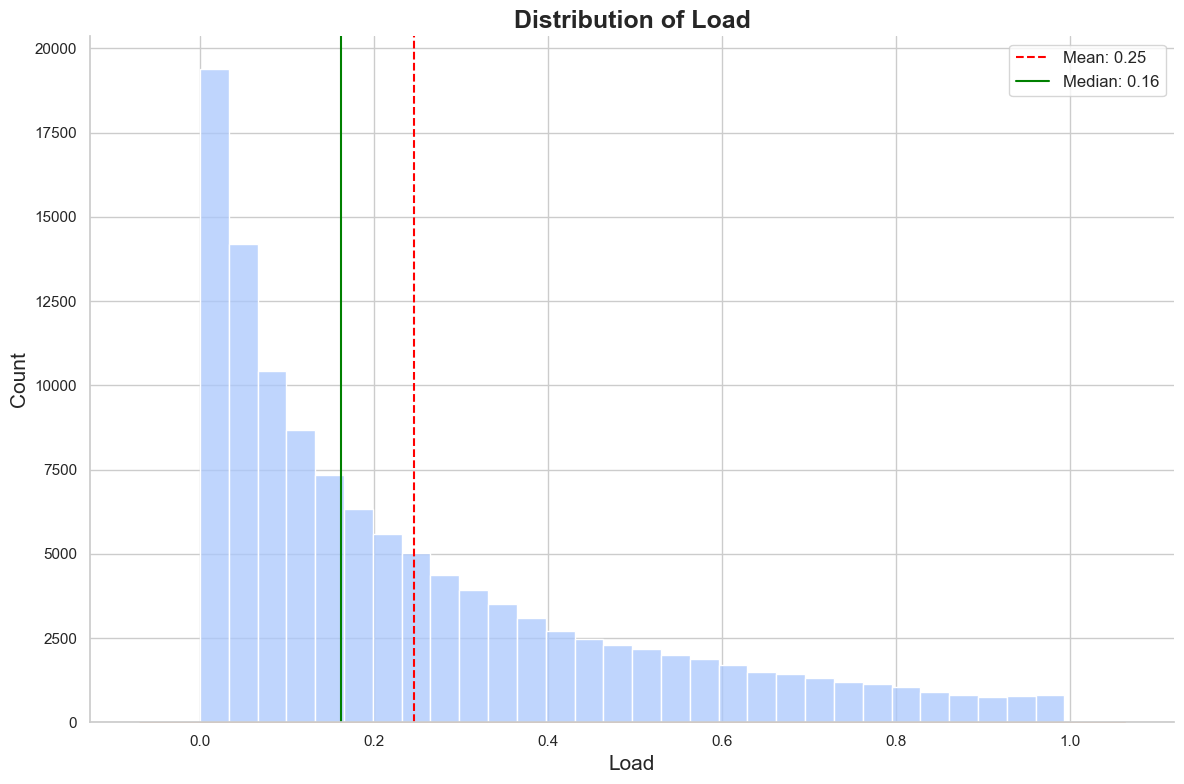

In [287]:
# Set style for seaborn plots
sns.set_style("whitegrid")

# Choose a fancy color palette
current_palette = sns.color_palette("coolwarm", 2)
sns.set_palette(current_palette)

# Plotting the distribution of 'Load'
plt.figure(figsize=(12, 8))
sns.histplot(merged_data['load'], bins=30, kde=False, color=current_palette[0]) 
sns.kdeplot(merged_data['load'], color=current_palette[1], shade=True)  # plot kde separately with shading

# Adding a vertical line for mean and median
mean_load = merged_data['load'].mean()
median_load = merged_data['load'].median()

plt.axvline(mean_load, color='red', linestyle='--', label=f"Mean: {mean_load:.2f}")
plt.axvline(median_load, color='green', linestyle='-', label=f"Median: {median_load:.2f}")

# Adjusting title and labels
plt.title('Distribution of Load', fontsize=18, fontweight='bold')
plt.xlabel('Load', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=12)

# Removing top and right spines for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()


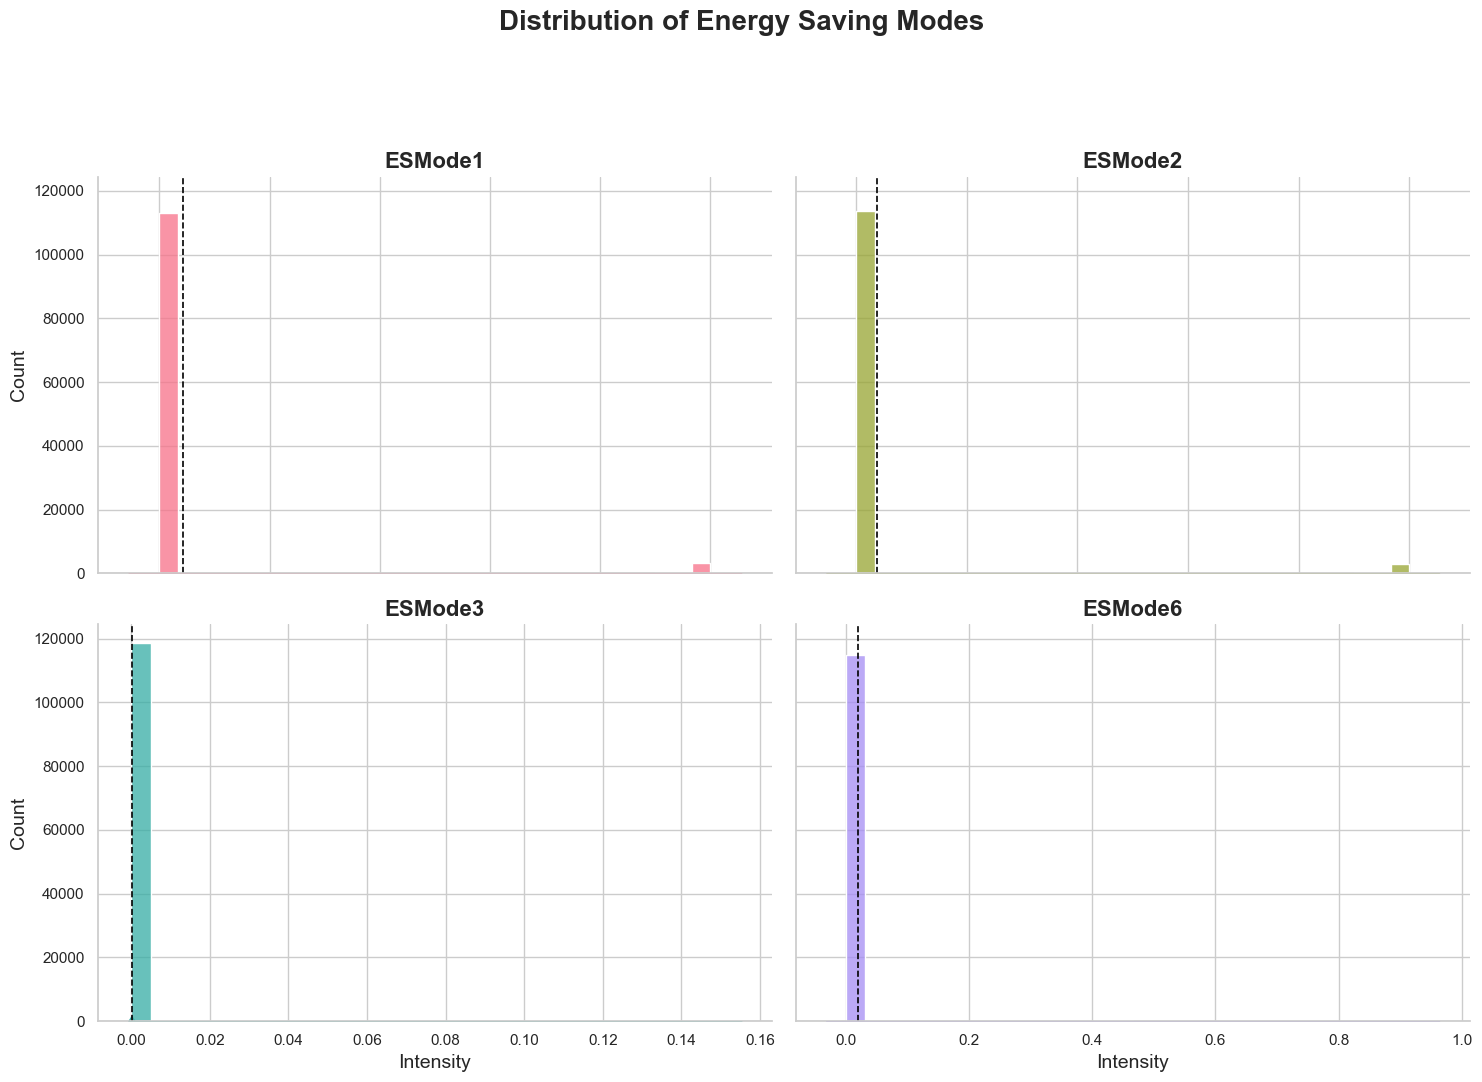

In [288]:
# Set style for seaborn plots
sns.set_style("whitegrid")

# Choose a consistent color palette
colors = sns.color_palette("husl", 4)

# Plotting the distributions of 'ESModes' columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Distribution of Energy Saving Modes', fontsize=20, fontweight='bold', y=1.08)

esmodes = ['ESMode1', 'ESMode2', 'ESMode3', 'ESMode6']

for i, mode in enumerate(esmodes):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    sns.histplot(merged_data[mode], bins=30, kde=False, ax=ax, color=colors[i])
    sns.kdeplot(merged_data[mode], shade=True, color=colors[i], ax=ax)
    
    # Adding a vertical line for mean
    mean_value = merged_data[mode].mean()
    ax.axvline(mean_value, color='black', linestyle='--', linewidth=1.2)
    
    # Set title and labels
    ax.set_title(mode, fontsize=16, fontweight='bold')
    ax.set_xlabel('Intensity', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.label_outer()  # Only show outer labels to reduce redundancy

# Set a uniform Y-axis for easier comparison
max_count = max(ax.get_ylim() for ax in axes.flatten())
for ax in axes.flatten():
    ax.set_ylim(0, max_count[1])

# Removing top and right spines for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()


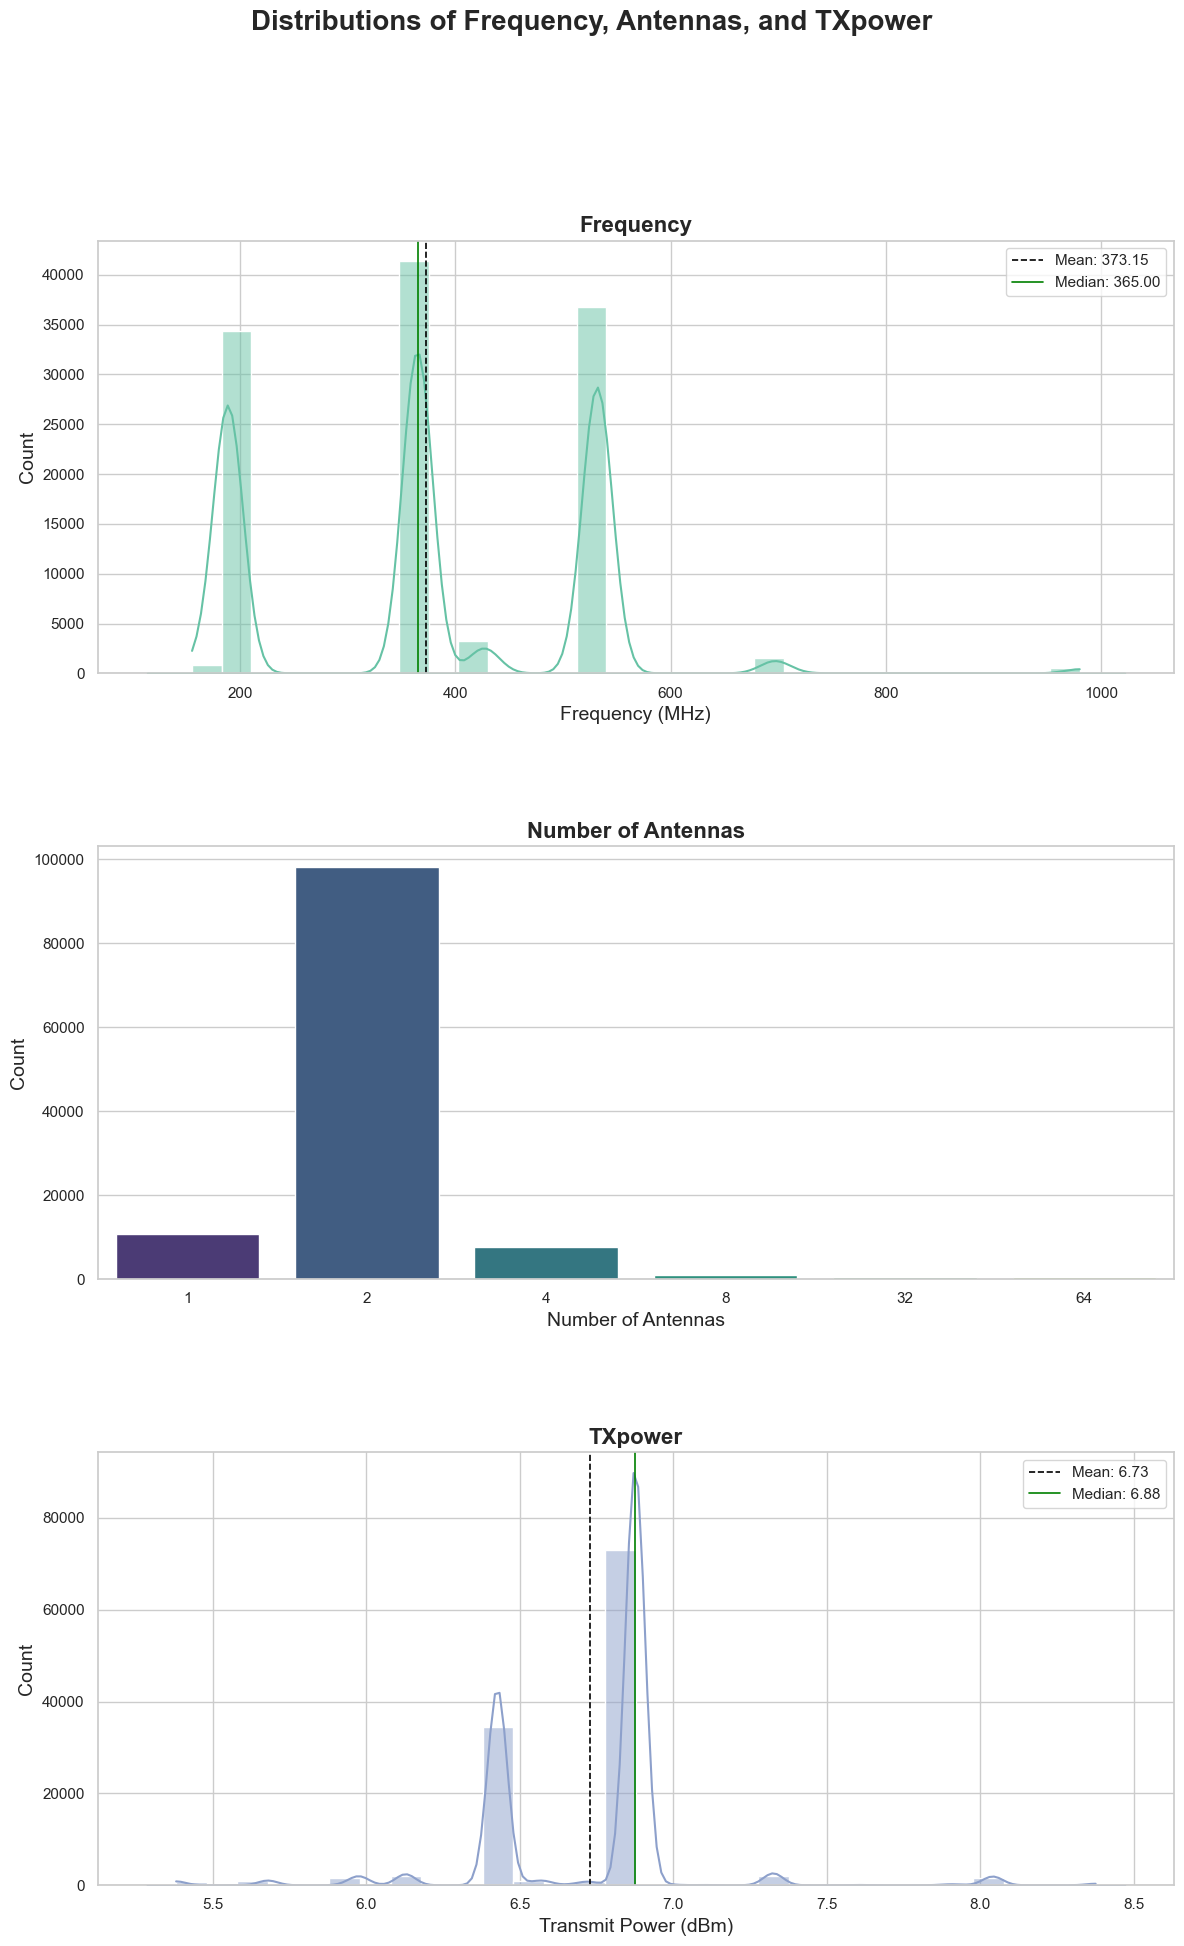

In [290]:
# Set style for seaborn plots
sns.set_style("whitegrid")

# Use a coordinated color palette
colors = sns.color_palette("Set2", 3)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
fig.suptitle('Distributions of Frequency, Antennas, and TXpower', fontsize=20, fontweight='bold', y=1.08)

# Plotting details
details = [
    {'data': 'Frequency', 'bins': 30, 'kde': True, 'color': colors[0], 'xlabel': 'Frequency (MHz)', 'title': 'Frequency'},
    {'data': 'Antennas', 'palette': 'viridis', 'xlabel': 'Number of Antennas', 'title': 'Number of Antennas'},
    {'data': 'TXpower', 'bins': 30, 'kde': True, 'color': colors[2], 'xlabel': 'Transmit Power (dBm)', 'title': 'TXpower'}
]

# details[data]
# details[1]['palette']

for i, detail in enumerate(details):
    ax = axes[i]
    
    if 'palette' in detail and detail['palette']:
    # if detail['palette']:
        sns.countplot(data=merged_data, x=detail['data'], ax=ax, palette=detail['palette'])
    else:
        sns.histplot(merged_data[detail['data']], bins=detail.get('bins', 30), kde=detail.get('kde', False), ax=ax, color=detail['color'])
        if detail.get('kde', False):
            sns.kdeplot(merged_data[detail['data']], shade=True, color=detail['color'], ax=ax)
            # Adding vertical lines for mean and median
            mean_value = merged_data[detail['data']].mean()
            median_value = merged_data[detail['data']].median()
            ax.axvline(mean_value, color='black', linestyle='--', linewidth=1.2, label=f"Mean: {mean_value:.2f}")
            ax.axvline(median_value, color='green', linestyle='-', linewidth=1.2, label=f"Median: {median_value:.2f}")
            ax.legend()
    
    # Set title and labels
    ax.set_title(detail['title'], fontsize=16, fontweight='bold')
    ax.set_xlabel(detail['xlabel'], fontsize=14)
    ax.set_ylabel('Count', fontsize=14)

# Spacing adjustment
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # Add more space between plots
plt.show()


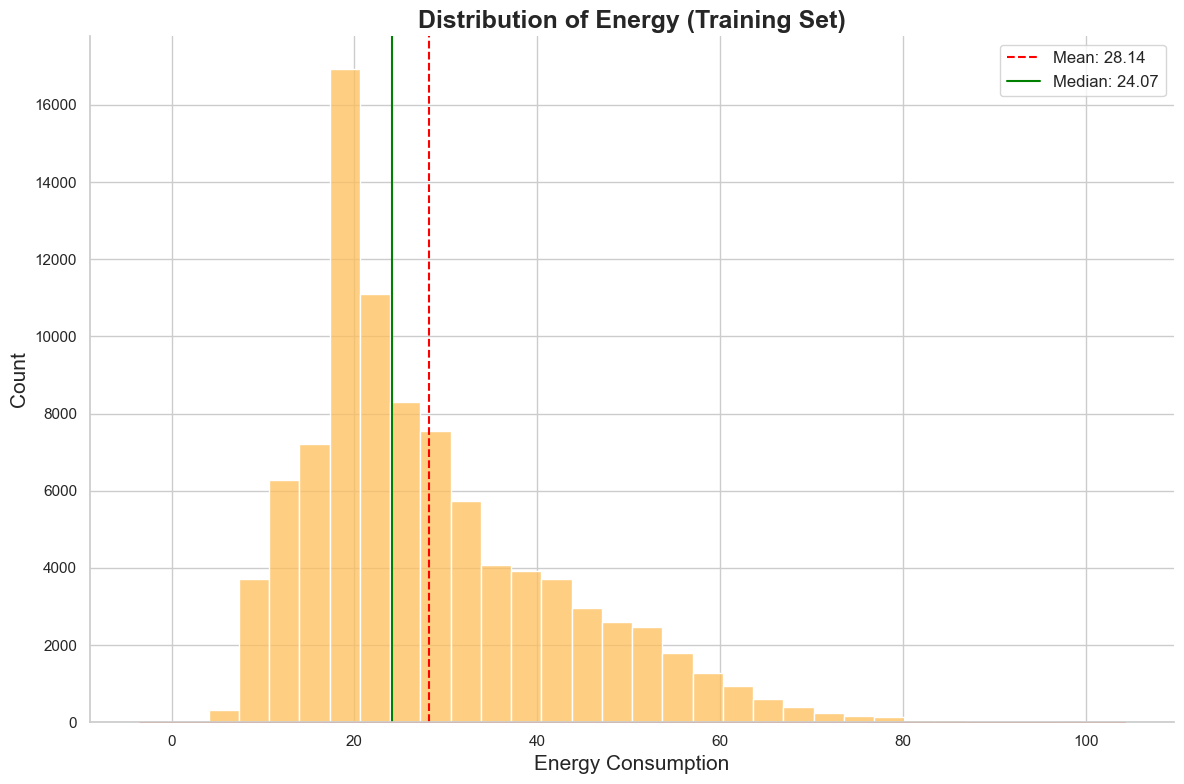

In [291]:
# Set style for seaborn plots
sns.set_style("whitegrid")

# Choose a color palette
current_palette = sns.color_palette("YlOrRd", 2)
sns.set_palette(current_palette)

# Filter out rows where 'Energy' is not missing (i.e., from the training set)
energy_data = merged_data[merged_data['Energy'].notnull()]

# Plotting the distribution of 'Energy'
plt.figure(figsize=(12, 8))
sns.histplot(energy_data['Energy'], bins=30, kde=False, color=current_palette[0])  # remove the kde here
sns.kdeplot(energy_data['Energy'], color=current_palette[1], shade=True)  # plot kde separately with shading

# Adding a vertical line for mean and median
mean_energy = energy_data['Energy'].mean()
median_energy = energy_data['Energy'].median()

plt.axvline(mean_energy, color='red', linestyle='--', label=f"Mean: {mean_energy:.2f}")
plt.axvline(median_energy, color='green', linestyle='-', label=f"Median: {median_energy:.2f}")

# Adjusting title and labels
plt.title('Distribution of Energy (Training Set)', fontsize=18, fontweight='bold')
plt.xlabel('Energy Consumption', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=12)

# Removing top and right spines for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()


### 2. Bivariate Analysis

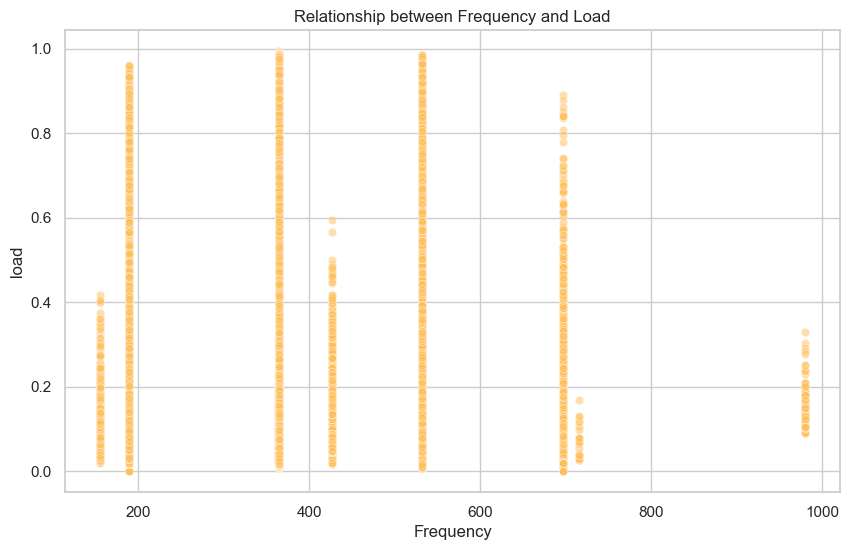

In [292]:
# Create a scatter plot of Frequency vs. load
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='Frequency', y='load', alpha=0.5)
plt.title('Relationship between Frequency and Load')
plt.show()


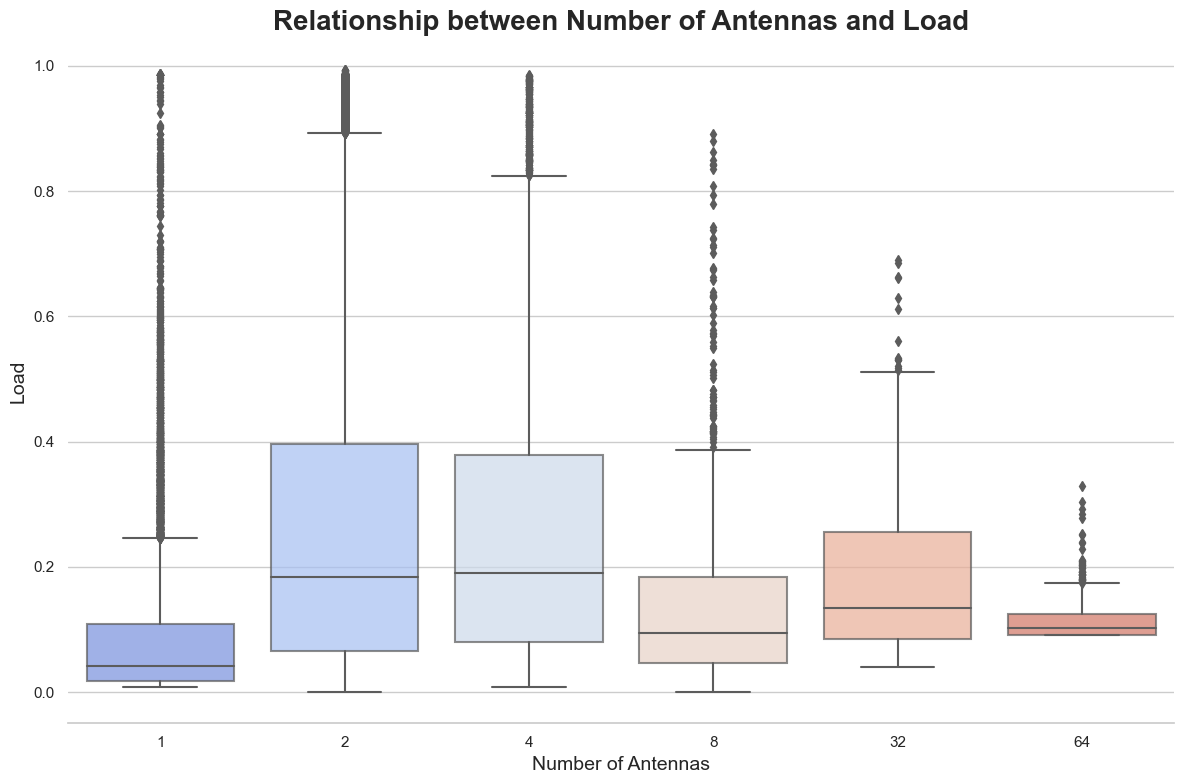

In [293]:
# Set the style of the visualization
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))

# Using a color palette for the boxplots
palette = sns.color_palette("coolwarm", n_colors=merged_data['Antennas'].nunique())

sns.boxplot(data=merged_data, x='Antennas', y='load', palette=palette, boxprops=dict(alpha=.7))

# Enhancing the title and labels
plt.title('Relationship between Number of Antennas and Load', fontsize=20, fontweight='bold')
plt.xlabel('Number of Antennas', fontsize=14)
plt.ylabel('Load', fontsize=14)

# Despine for a cleaner look
sns.despine(left=True)

# Display the plot
plt.tight_layout()
plt.show()


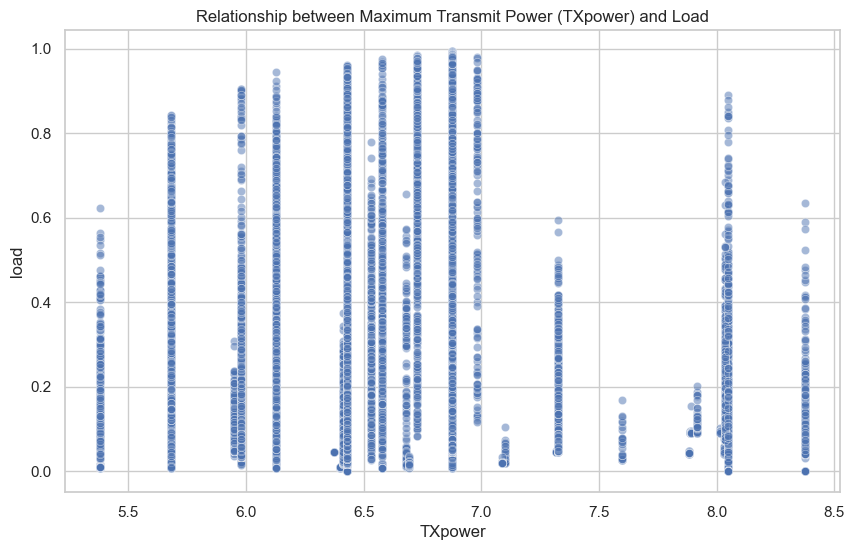

In [294]:
# Create a scatter plot of TXpower vs. load
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='TXpower', y='load', alpha=0.5)
plt.title('Relationship between Maximum Transmit Power (TXpower) and Load')
plt.show()


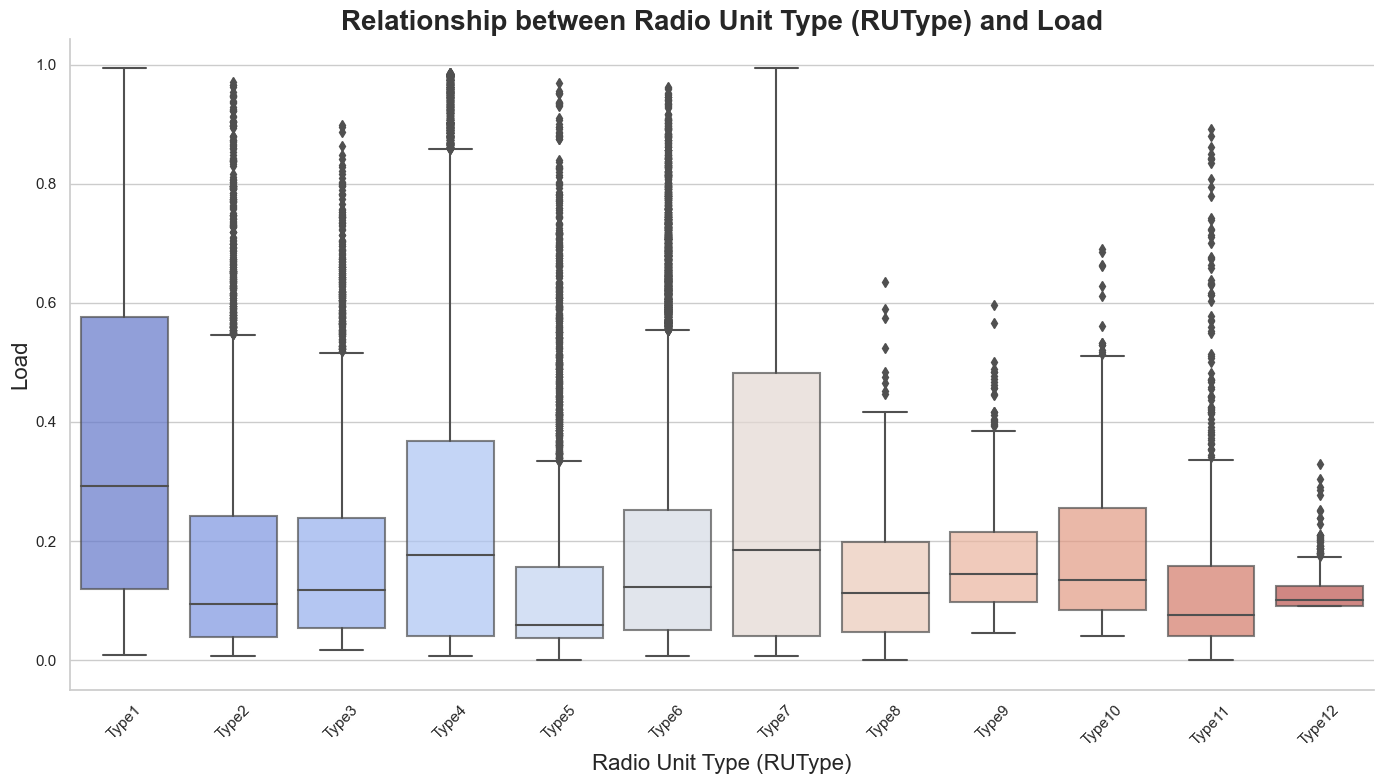

In [295]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a color palette for the boxplots
palette = sns.color_palette("coolwarm", n_colors=merged_data['RUType'].nunique())

plt.figure(figsize=(14, 8))

# Create a box plot for RUType vs. load
sns.boxplot(data=merged_data, x='RUType', y='load', palette=palette, boxprops=dict(alpha=.7))

# Optionally overlay the swarmplot to show individual data points. This is computationally expensive for large datasets.
# sns.swarmplot(data=merged_data, x='RUType', y='load', color=".25", size=2)

# Enhancing the title and labels
plt.title('Relationship between Radio Unit Type (RUType) and Load', fontsize=20, fontweight='bold')
plt.xlabel('Radio Unit Type (RUType)', fontsize=16)
plt.ylabel('Load', fontsize=16)

plt.xticks(rotation=45)

# Despine for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()


### 3. Correlation Analysis

In [296]:
# Calculating correlation matrix for the merged data
correlation_matrix = merged_data.select_dtypes(include=['int', 'float']).corr()

# Extracting correlations related to 'Energy'
energy_correlations = correlation_matrix['Energy'].sort_values(ascending=False)

energy_correlations


Energy          1.000000
Frequency_1     0.730340
Antennas_1      0.728242
TXpower_1       0.721493
load_sum        0.688373
load            0.668345
Bandwidth_1     0.657522
Bandwidth       0.341766
active_cells    0.267505
ESMode3_1       0.266937
ESMode2_1       0.264769
ESMode1_1       0.264159
ESMode6_1       0.263154
TXpower         0.253033
load_mult       0.250334
load_1          0.242942
Antennas        0.170925
ESMode3         0.016501
Frequency       0.012707
ESMode6        -0.061041
ESMode2        -0.270284
ESMode1        -0.272003
train                NaN
Name: Energy, dtype: float64

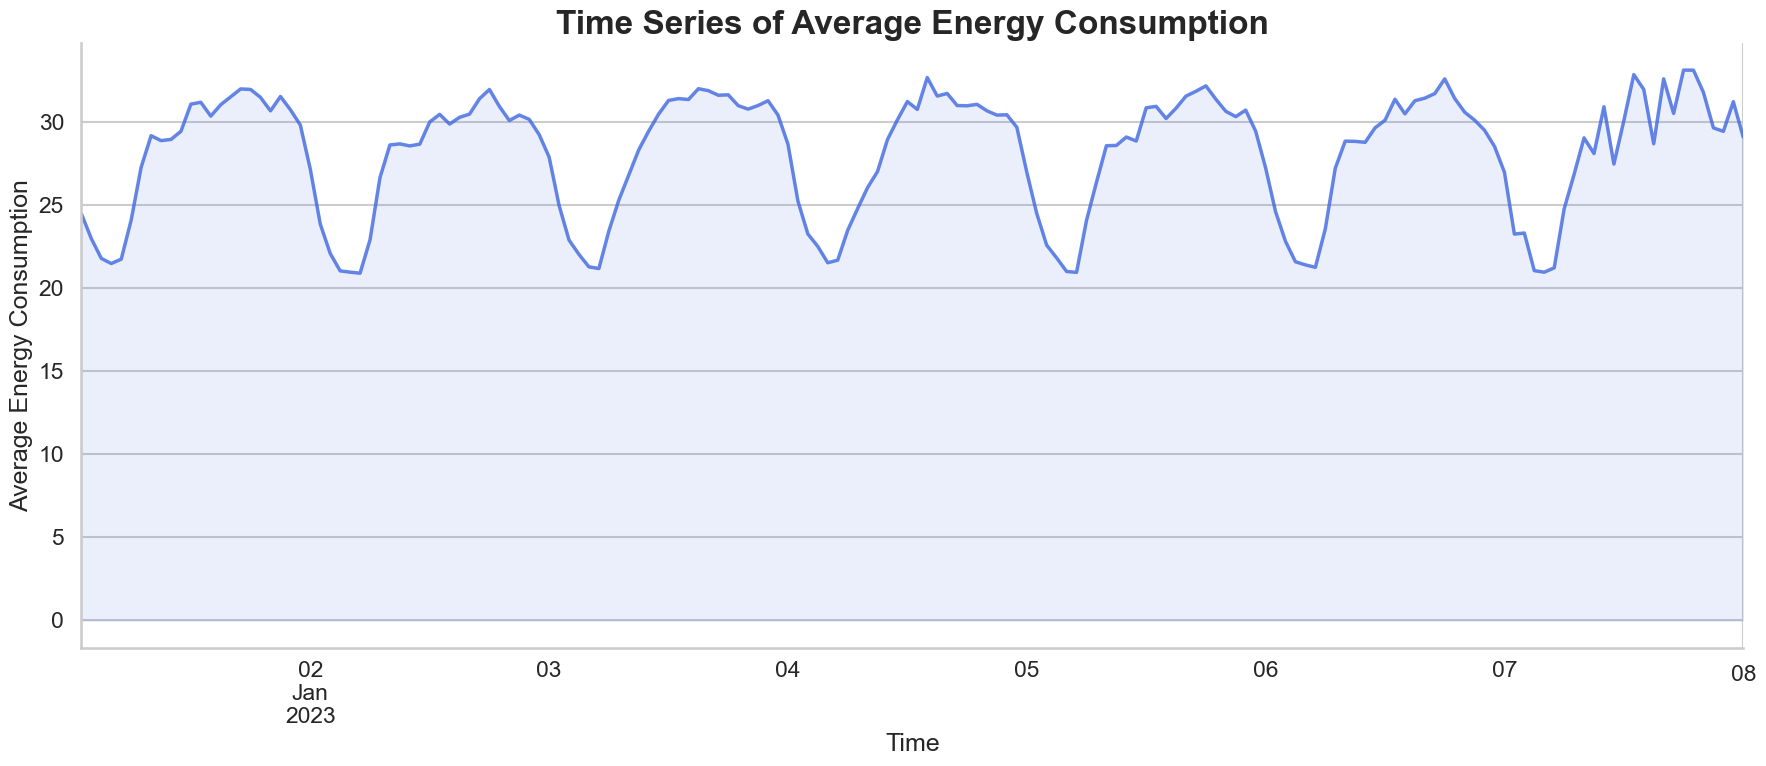

In [297]:
# Set the style and context
sns.set_style("whitegrid")
sns.set_context("talk")

plt.figure(figsize=(18, 8))

# Extract series
avg_energy = merged_data.groupby('Time')['Energy'].mean()

# Plotting with enhanced aesthetics
avg_energy.plot(linewidth=2.5, color='royalblue', alpha=0.8)

# Fill below the line
plt.fill_between(avg_energy.index, avg_energy.values, color='royalblue', alpha=0.1)

# Enhancing the title and labels
plt.title('Time Series of Average Energy Consumption', fontsize=24, fontweight='bold')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Average Energy Consumption', fontsize=18)

# Despine for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()


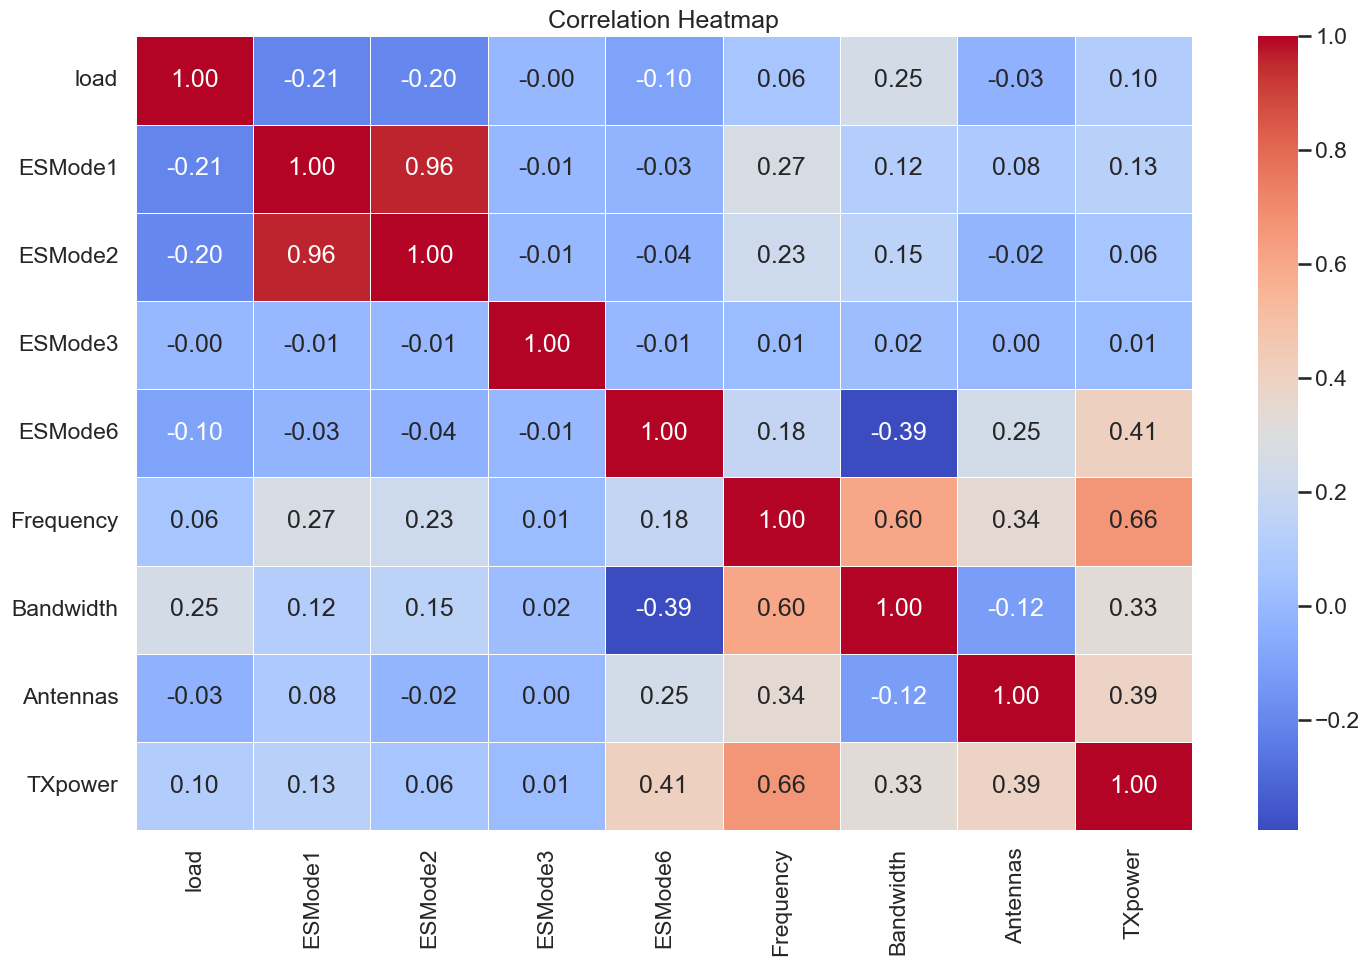

In [298]:
cols = ['load', 'ESMode1', 'ESMode2', 'ESMode3', 'ESMode6', 'Frequency', 'Bandwidth', 'Antennas', 'TXpower']
correlation_matrix = merged_data[cols].corr()

# Heatmap of correlations
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


# Feature Engineering 

### Count of Base Stations Records

In [299]:
# Count the number of records for each base station
BS_count = merged_data["BS"].value_counts()

# Map the count to a new column
merged_data["BS_count"] = merged_data["BS"].map(BS_count)

### Temporal Feature Engineering

- **Hour**
- **Hour_sin** and **Hour_cos**
- **hour_class**
- **Day_of_week**
- **Is_weekend**
- **Day_of_month**


In [300]:
def classify_hour(hour):
    if 1 <= hour <= 5:
        return 1
    elif 6 <= hour <= 7:
        return 2
    else:
        return 3

# Create new temporal features
merged_data['Hour'] = merged_data['Time'].dt.hour
merged_data['Hour_sin'] = np.sin(2*np.pi*merged_data['Hour']/24)
merged_data['Hour_cos'] = np.cos(2*np.pi*merged_data['Hour']/24)
merged_data['hour_class'] = merged_data['Hour'].apply(classify_hour)
merged_data['Day_of_week'] = merged_data['Time'].dt.dayofweek
merged_data['Is_weekend'] = (merged_data['Day_of_week'] >= 5).astype(int)
merged_data['Day_of_month'] = merged_data['Time'].dt.day

### Encoding Categorical Features

In [301]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
merged_data[['BS', 'Mode', 'RUType']] = ordinal_encoder.fit_transform(merged_data[['BS', 'Mode', 'RUType']])

### Power Utilization Ratio

In [302]:
merged_data['Power_Utilization_Ratio'] = merged_data['load'] / (merged_data['TXpower'] + 1e-3)
merged_data['Power_Utilization_Ratio_1'] = merged_data['load_1'] / (merged_data['TXpower_1'] + 1e-3)

### Energy Saving Intensity

In [303]:
energy_saving_modes = ['ESMode1', 'ESMode2', 'ESMode6',  'ESMode3']
merged_data['Energy_Saving_Intensity'] = merged_data[energy_saving_modes].sum(axis=1)

### Aggregative Feature Engineering

In [304]:
cols = ['load']
aggs = ['BS']

for agg in tqdm(aggs):
    for col in cols: 
        std = merged_data.groupby(agg)[col].std()
        mean = merged_data.groupby(agg)[col].mean()
        min_ = merged_data.groupby(agg)[col].min()
        max_ = merged_data.groupby(agg)[col].max()
        merged_data[agg+ "_std_"+col] = merged_data[agg].map(std)
        merged_data[agg+ "_mean_"+col] = merged_data[agg].map(mean)
        merged_data[agg+ "_min_"+col] = merged_data[agg].map(min_)
        merged_data[agg+ "_max_"+col] = merged_data[agg].map(max_)


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


## `predict_next_load` Function Overview

In [308]:
import xgboost as xgb


def predict_next_load(dataframe):
    """
    Predicts the next load value based on historical load data.
    
    Parameters:
    - dataframe (DataFrame): The data containing BS, Time, load and other features.

    Returns:
    - dataframe (DataFrame): The data with an additional column for the predicted next load value.
    """
    
    # Sort the dataframe by the 'Time' column.
    dataframe = dataframe.sort_values(by='Time')
    
    # Get unique Base Station identifiers.
    unique_base_stations = dataframe.BS.unique()
    
    # Loop over each unique Base Station.
    for base_station in tqdm(unique_base_stations):
        # Extract Time and load data for the current Base Station.
        station_data = dataframe[dataframe.BS == base_station][["Time", 'load']]
        
        # Set the Time as the index for the dataframe.
        station_time_indexed = station_data.set_index('Time')
        
        # Create a continuous hourly date range.
        continuous_hourly_range = pd.date_range(start=station_time_indexed.index.min(), end=station_time_indexed.index.max(), freq='H')
        
        # Reindex to ensure all hours are represented.
        station_hourly_data = station_time_indexed.reindex(continuous_hourly_range)
        
        # Fill missing load values using linear interpolation.
        station_hourly_data_interpolated = station_hourly_data.interpolate(method='linear')
        
        # Determine the subsequent load by shifting the data by 1 hour.
        subsequent_load = station_hourly_data_interpolated.shift(-1).interpolate().loc[station_data.Time].values
        
        # Update the main dataframe with the subsequent load values.
        dataframe.loc[dataframe.BS == base_station, 'next_load'] = subsequent_load
    
    # Re-sort the dataframe based on its original order.
    dataframe = dataframe.sort_index()
    
    # Prepare features and target data for model training.
    features = dataframe.drop(["Time", 'Energy', 'train', 'next_load'], axis=1)
    target = dataframe["next_load"]
    
    # Initialize the XGBoost model.
    xgboost_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        # tree_method='gpu_hist',
        tree_method='hist',
        n_estimators=700,
        learning_rate=0.3,
        max_depth = 11,
        random_state=0)
    
    # Train the model with the data.
    xgboost_model.fit(features, target)
    
    # Make predictions and update the main dataframe.
    dataframe['next_load'] = xgboost_model.predict(features)
    
    return dataframe

merged_data = predict_next_load(merged_data)

  7%|▋         | 72/1020 [00:01<00:12, 78.67it/s]

100%|██████████| 1020/1020 [00:10<00:00, 101.80it/s]


In [309]:
merged_data = merged_data.loc[:, merged_data.nunique() > 1]

# Modelling 

### train test split

In [312]:
train = merged_data[merged_data.train==1].drop(['Time', 'train'],axis=1).astype(float)
train = train.sample(len(train), random_state=93)
test = merged_data[merged_data.train==0].drop(['Time','train','Energy'],axis=1).astype(float)

In [313]:
from sklearn.model_selection import train_test_split

# Splitting the data into features (X) and target (y)
X = train.drop(columns=['Energy'])
y = train['Energy']


### Model: XGBoost

In [314]:
cols =['BS', 'load', 'ESMode1', 'ESMode2', 'ESMode3', 'ESMode6',
       'active_cells', 'load_1', 'load_sum', 'load_mult', 'RUType', 'Mode', 'Frequency',
       'Bandwidth', 'Antennas', 'TXpower', 'Frequency_1', 'Bandwidth_1',
       'Antennas_1', 'TXpower_1', 'BS_count', 'Hour', 'Hour_sin', 'Hour_cos',
       'hour_class', 'Day_of_week', 'Is_weekend', 'Day_of_month',
       'Energy_Saving_Intensity', 
       'BS_std_load', 'BS_mean_load', 'BS_min_load',
       'BS_max_load', 'next_load']

In [315]:
from sklearn.model_selection import GroupKFold

# Reset index of X and y
X1 = X.reset_index(drop=True)
y1 = y.reset_index(drop=True)

def generate_groups(df, feature='BS'):
    """
    Generate groups based on unique values of a specified feature.
    The groups are mapped to integers with modulo 5.
    """
    unique_vals = df[feature].unique()
    num_unique_vals = len(unique_vals)
    return df[feature].map({val: i % 5 for i, val in enumerate(unique_vals)}).values

def train_model(X_train, y_train):
    """
    Train the XGBoost model using given training data.
    """
    model = xgb.XGBRegressor(
        objective='reg:gamma',
        # tree_method='gpu_hist',
        tree_method='hist',
        n_estimators=2100,
        learning_rate=0.05,
        colsample_bytree=0.7,
        subsample=0.8,
        random_state=0,
        max_depth=7,
        reg_lambda=5
    )
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on the test data and return the mean absolute error.
    """
    predictions = model.predict(X_test)
    return mean_absolute_error(y_test, predictions)

# Generating groups
groups = generate_groups(X)

# Splitting the data using GroupKFold
gkf = GroupKFold(n_splits=5)
splits = gkf.split(X, y, groups)

# Training and evaluating the model on each fold
losses = []
for fold, (train_idx, test_idx) in enumerate(splits):
    X_train, X_test = X1.iloc[train_idx], X1.iloc[test_idx]
    y_train, y_test = y1.iloc[train_idx], y1.iloc[test_idx]
    
    model = train_model(X_train, y_train)
    loss = evaluate_model(model, X_test, y_test)
    losses.append(loss)

# Calculating and printing the average loss
average_loss = sum(losses) / 5
print(average_loss)


2.3461920201793696


**XGBoost Model for Energy Prediction**

**Why Gamma Regression?** 🤔

The choice of using the `reg:gamma` objective stems from the observation that the distribution of `Energy` closely resembles a **Gamma Distribution**.


In [ ]:
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size=0.2, random_state=42)

# # Initialize XGBoost regressor
# params = {
#     'objective': 'reg:gamma',
#     'tree_method': 'hist',
#     'n_estimators': 2100,
#     'learning_rate': 0.05,
#     'colsample_bytree': 0.7,
#     'subsample': 0.8,
#     'random_state': 0,
#     'max_depth': 7,
#     'reg_lambda': 5
# }

# xgb_regressor = xgb.XGBRegressor(**params)

# # Train the model
# xgb_regressor.fit(X[cols], y, eval_set=[(X_train, y_train), (X_test, y_test)],
#                       eval_metric='mae', verbose=0)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2100, n_jobs=None,
             num_parallel_tree=None, objective='reg:gamma', ...)

In [354]:
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size=0.2, random_state=42)

# # Initialize XGBoost regressor
# params = {
#     'objective': 'reg:gamma',
#     'tree_method': 'hist',
#     'n_estimators': 1800,
#     'learning_rate': 0.01,
#     'colsample_bytree': 0.6,
#     'subsample': 0.7,
#     'random_state': 0,
#     'max_depth': 6,
#     'reg_lambda': 4
# }

# xgb_regressor = xgb.XGBRegressor(**params)

# # Train the model
# xgb_regressor.fit(X[cols], y, eval_set=[(X_train, y_train), (X_test, y_test)],
#                       eval_metric='mae', verbose=0)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1800, n_jobs=None,
             num_parallel_tree=None, objective='reg:gamma', ...)

In [365]:
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size=0.2, random_state=42)

# # Initialize XGBoost regressor
# params = {
#     'objective': 'reg:gamma',
#     'tree_method': 'hist',
#     'n_estimators': 3000,
#     'learning_rate': 0.1,
#     'colsample_bytree': 0.8,
#     'subsample': 0.9,
#     'random_state': 0,
#     'max_depth': 8,
#     'reg_lambda': 6
# }

# xgb_regressor = xgb.XGBRegressor(**params)

# # Train the model
# xgb_regressor.fit(X[cols], y, eval_set=[(X_train, y_train), (X_test, y_test)],
#                       eval_metric='mae', verbose=0)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, objective='reg:gamma', ...)

In [377]:
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size=0.2, random_state=42)

# # Initialize XGBoost regressor
# params = {
#     'objective': 'reg:gamma',
#     'tree_method': 'hist',
#     'n_estimators': 3000,
#     'learning_rate': 0.05,
#     'colsample_bytree': 0.7,
#     'subsample': 0.8,
#     'random_state': 0,
#     'max_depth': 7,
#     'reg_lambda': 5
# }

# xgb_regressor = xgb.XGBRegressor(**params)

# # Train the model
# xgb_regressor.fit(X[cols], y, eval_set=[(X_train, y_train), (X_test, y_test)],
#                       eval_metric='mae', verbose=0)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, objective='reg:gamma', ...)

In [387]:
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size=0.2, random_state=42)

# # Initialize XGBoost regressor
# params = {
#     'objective': 'reg:gamma',
#     'tree_method': 'hist',
#     'n_estimators': 4000,
#     'learning_rate': 0.05,
#     'colsample_bytree': 0.7,
#     'subsample': 0.8,
#     'random_state': 0,
#     'max_depth': 7,
#     'reg_lambda': 5
# }

# xgb_regressor = xgb.XGBRegressor(**params)

# # Train the model
# xgb_regressor.fit(X[cols], y, eval_set=[(X_train, y_train), (X_test, y_test)],
#                       eval_metric='mae', verbose=0)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=4000, n_jobs=None,
             num_parallel_tree=None, objective='reg:gamma', ...)

In [397]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size=0.2, random_state=42)

# Initialize XGBoost regressor
params = {
    'objective': 'reg:gamma',
    'tree_method': 'hist',
    'n_estimators': 4000,
    'learning_rate': 0.06,
    'colsample_bytree': 0.7,
    'subsample': 0.8,
    'random_state': 0,
    'max_depth': 7,
    'reg_lambda': 5
}

xgb_regressor = xgb.XGBRegressor(**params)

# Train the model
xgb_regressor.fit(X[cols], y, eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric='mae', verbose=0)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=4000, n_jobs=None,
             num_parallel_tree=None, objective='reg:gamma', ...)

In [398]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on the test set
y_pred = xgb_regressor.predict(X_test)

# Calculate and print the evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 0.2327257997427415
R2 Score: 0.999202843296281
MSE: 0.1559706213262651
RMSE: 0.39493116023715463


In [399]:
import pickle

# Save the model as pkl
filename = 'model_6.pkl'
pickle.dump(xgb_regressor, open(filename, 'wb'))

# Post processing

In [317]:
print(f"There are {len(y.unique())} unique energy values")

There are 612 unique energy values


In [400]:
def transform_vector(v, b):
    diffs = np.abs(b[:, None] - v)
    indices = np.argmin(diffs, axis=0)
    return b[indices]

def get_transformed_energy(row):
    bs = row['BS']
    energy = np.array([row['Energy']])
    
    if bs in unique_values:
        closest_values = np.array(unique_values[bs])
        return transform_vector(energy, closest_values)[0]
    else:
        return energy[0]

test['Energy'] = xgb_regressor.predict(test[cols])
unique_values = {k: list(v['Energy'].unique()) for k, v in train.groupby('BS') if len(v) > 50}

test['Energy'] = test.apply(get_transformed_energy, axis=1)
preds = test['Energy'].values


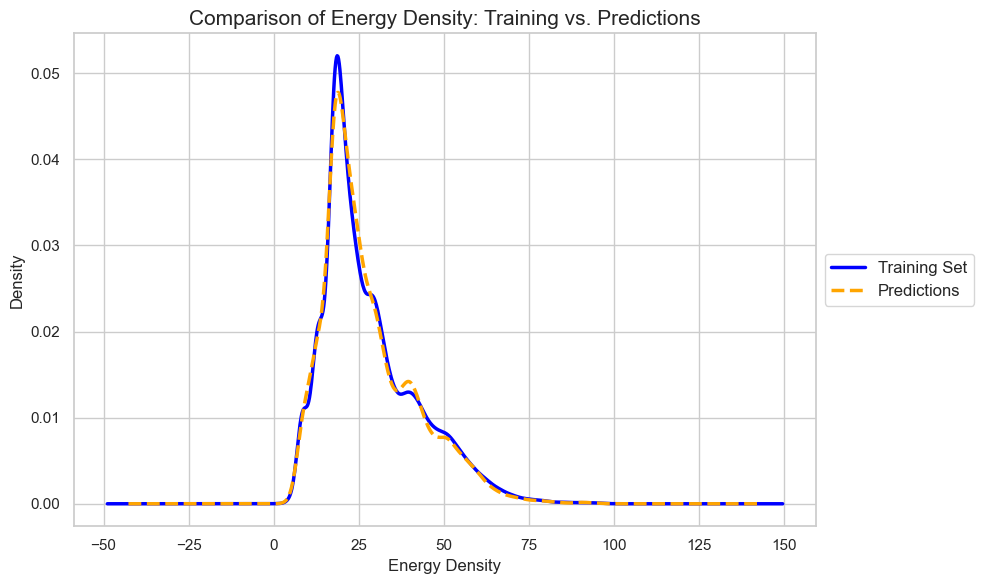

In [401]:
# Set style and context for seaborn for a better look
sns.set_style("whitegrid")
sns.set_context("notebook")

# Create the density plot
fig, ax = plt.subplots(figsize=(10, 6))  # setting a figure size

# Plotting the density of y_train
y.plot.density(ax=ax, label='Training Set', color='blue', linewidth=2.5)

# Plotting the density of preds
pd.Series(preds).plot.density(ax=ax, label='Predictions', color='orange', linewidth=2.5, linestyle='--')

# Setting the title and labels
ax.set_title('Comparison of Energy Density: Training vs. Predictions', fontsize=15)
ax.set_xlabel('Energy Density', fontsize=12)
ax.set_ylabel('Density', fontsize=12)

# Showing the legend to identify each line, and position it outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Displaying the plot
plt.tight_layout()
plt.show()


In [402]:
sample_submission = pd.read_csv(r'C:\Users\nadil\OneDrive\Documents\UoM\Sem 5\DSE Project\5g-energy-consumption-modeling\Dataset\SampleSubmission.csv').drop("w", axis=1)

In [403]:
sample_submission["Energy"] = preds

In [404]:
sample_submission['Time'] = sample_submission['Time'].astype(str) + '_' + sample_submission['BS'].astype(str)
sample_submission.drop(columns=['BS'], inplace=True)

In [405]:
sample_submission.to_csv("sub6.csv", index=False)

# MLFLOW Logging

In [348]:
import dagshub
dagshub.init(repo_owner='samithkavishke', repo_name='5g-energy-consumption-modeling', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=4367d871-d0df-4e13-9d39-ce89b867aeba&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=fe9cbb8cb335093d483ba685aab1e78daed4bd3abee133e2fe975c81055f58c2




Output()

Repository initialized!

In [349]:
MLFLOW_TRACKING_URI="https://dagshub.com/samithkavishke/5g-energy-consumption-modeling.mlflow"
MLFLOW_TRACKING_USERNAME="Nadil-K"
MLFLOW_TRACKING_PASSWORD="4d491efdd25e4710cc1ad56f26f6f0a9b9bde0a8"

In [350]:
import mlflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("Competition")

<Experiment: artifact_location='mlflow-artifacts:/05e4fbc588934e979ba8497f14f54669', creation_time=1698146260875, experiment_id='0', last_update_time=1698146260875, lifecycle_stage='active', name='Competition', tags={}>

In [396]:
with mlflow.start_run():
    # Log the model parameters
    mlflow.log_params(params)
    mlflow.log_param("Public Score", '0.082340280')
    mlflow.log_param("Private Score", '0.080560573')
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2", r2)
    mlflow.log_artifact('model_6.pkl')
    mlflow.log_artifact('sub6.csv')
mlflow.end_run()